# Problem Statement

**Predict the following locations:**
- Kyoto (Japan)
- Liestal-Weideli (Switzerland)
- Washington, D.C. (USA)
- Vancouver, BC (Canada)
- New York City, NY (USA)

# Environment Configuration
----

## Import libraries

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

## Utility functions

In [2]:
def get_interval(y_pred, alpha=0.99):
    # Calculate prediction intervals using quantiles
    alpha = 0.99  # Confidence level
    quantile_lower = (1 - alpha) / 2
    quantile_upper = (1 + alpha) / 2
    
    # Assuming y_pred is a 1-dimensional array
    sorted_indices = np.argsort(y_pred)
    n = len(y_pred)
    
    # Calculate lower and upper bounds for prediction intervals
    lower_index = int(np.floor(quantile_lower * n))
    upper_index = int(np.floor(quantile_upper * n))
    
    lower_bound = y_pred[sorted_indices[lower_index]]
    upper_bound = y_pred[sorted_indices[upper_index]]
    
    # Output the results in the desired format
    return pd.DataFrame({'Prediction': y_pred, 'Lower': lower_bound, 'Upper': upper_bound})

In [3]:
def evaluate_model(y_test, y_pred_int):
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred_int)
    r2 = r2_score(y_test, y_pred_int)
    
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

In [4]:
def get_predictions(x, model):
    # Make predictions
    y_pred = model.predict(x)
    
    # Convert predictions to integers
    y_pred_int = np.round(y_pred).astype(int)

    return y_pred_int

# Prepare the data
----

## Load data

In [20]:
# Load kyoto dataframe
data = pd.read_csv("../data/cleaned/combined.csv")

# Remove metadata columns
data = data.drop(columns=['location', 'lat', 'long', 'alt', 'year', 'bloom_date'])

## Normalize data

In [24]:
# Normalize the data
norm_df = (data - data.min()) / (data.max() - data.min())

# Correlation matrix
min_max_corr = norm_df.corr()
# min_max_corr.to_csv("min_max_norm_corr.csv")

## Train-test split

In [25]:
# Split features (X) and target variable (y)
X = data.drop(columns=['bloom_doy'])
y = data['bloom_doy']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Scale data

In [26]:
scaler = StandardScaler()

In [27]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Evaluate Models
----

In [28]:
# Choose a threshold (e.g., 95% of cumulative importance) for importance
threshold = 0.95

## 1. Random Forest Regressor

### Initial Version

In [29]:
# Initialize and train the model (Random Forest Regressor used as an example)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [30]:
y_pred_int = get_predictions(X_test_scaled, model)

In [31]:
evaluate_model(y_test, y_pred_int)

Mean Squared Error: 91.05555555555556
R-squared: 0.8007549038735724


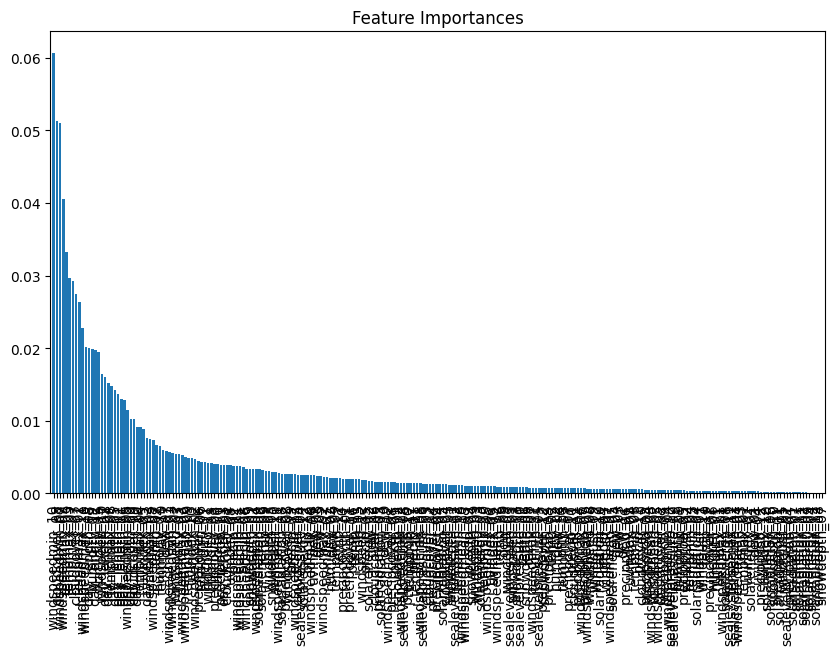

In [32]:
# Get feature importances
feature_importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

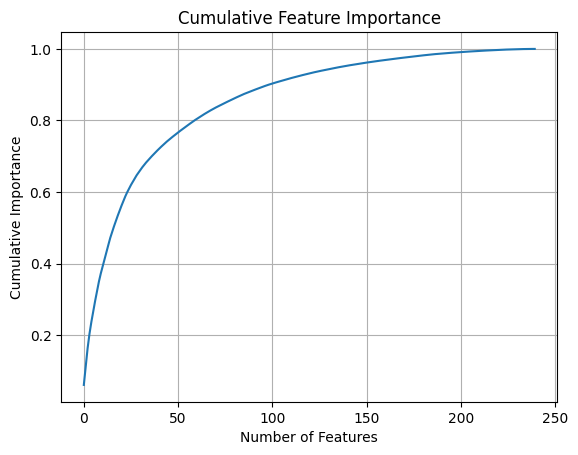

Number of features:  138
Selected Features: Index(['windspeedmin_10', 'cloudcover_08', 'windspeedmin_07',
       'windspeedmin_09', 'tempmax_06', 'tempmax_05', 'tempmax_07',
       'cloudcover_07', 'tempmax_02', 'windspeedmax_11',
       ...
       'windspeedmean_03', 'precip_09', 'snowdepth_04', 'windspeed_09',
       'windspeed_03', 'solarenergy_03', 'tempmin_10', 'windspeedmax_05',
       'uvindex_06', 'uvindex_03'],
      dtype='object', length=138)


In [33]:
cumulative_importance = np.cumsum(feature_importances[indices])
plt.plot(range(len(cumulative_importance)), cumulative_importance)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.grid(True)
plt.show()

selected_features = X.columns[indices][:np.argmax(cumulative_importance >= threshold) + 1]
print("Number of features: ", len(selected_features))
print("Selected Features:", selected_features)

### Optimal Version

In [34]:
# Subset the data based on the selected features
X_train_scaled_opt = scaler.fit_transform(X_train[selected_features.tolist()])
X_test_scaled_opt = scaler.transform(X_test[selected_features.tolist()])

In [35]:
# Initialize and train the model (Random Forest Regressor used as an example)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled_opt, y_train)

RandomForestRegressor(random_state=42)

In [36]:
y_pred_int = get_predictions(X_test_scaled_opt, model)

In [37]:
evaluate_model(y_test, y_pred_int)

Mean Squared Error: 91.62962962962963
R-squared: 0.7994987318215245


## 2. Gradient Booster Regression

### Initial Version

In [60]:
# Initialize and train the Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(random_state=42)

In [61]:
y_pred_int = get_predictions(X_test_scaled, model)

In [62]:
evaluate_model(y_test, y_pred_int)

Mean Squared Error: 89.16666666666667
R-squared: 0.8048881151416007


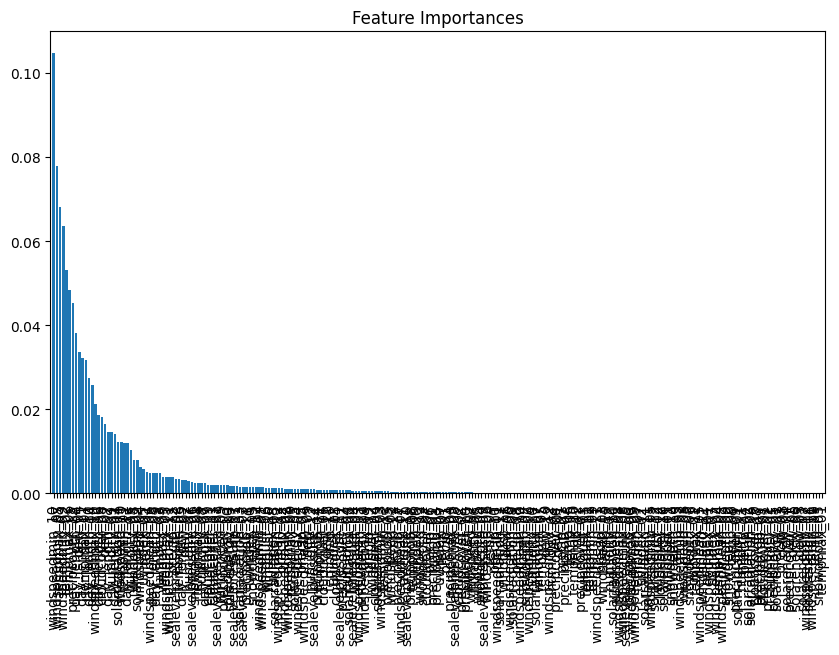

In [63]:
# Get feature importances
feature_importances = model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

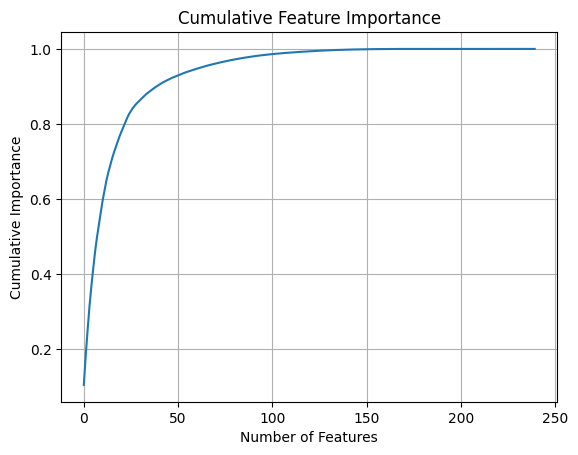

Number of features:  63
Selected Features: Index(['windspeedmin_10', 'windspeedmin_07', 'tempmax_05', 'windspeedmin_09',
       'tempmax_02', 'tempmax_06', 'precipcover_12', 'day_length_08', 'dew_04',
       'day_length_11', 'tempmax_07', 'day_length_10', 'day_length_04',
       'windspeedmax_10', 'day_length_06', 'cloudcover_08', 'dew_07',
       'day_length_02', 'humidity_09', 'day_length_01', 'solarradiation_04',
       'windspeed_10', 'tempmin_01', 'day_length_12', 'humidity_05',
       'windgust_08', 'solarenergy_02', 'windspeed_04', 'uvindex_05',
       'temp_01', 'windspeedmean_06', 'day_length_03', 'day_length_09',
       'uvindex_03', 'windgust_09', 'windspeedmax_05', 'windspeedmax_11',
       'precip_12', 'sealevelpressure_02', 'tempmin_08', 'day_length_05',
       'dew_02', 'humidity_07', 'sealevelpressure_06', 'snowdepth_01',
       'tempmax_08', 'humidity_08', 'day_length_07', 'cloudcover_09',
       'cloudcover_11', 'cloudcover_03', 'sealevelpressure_01', 'windspeed_09',


In [64]:
cumulative_importance = np.cumsum(feature_importances[indices])
plt.plot(range(len(cumulative_importance)), cumulative_importance)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.grid(True)
plt.show()

selected_features = X.columns[indices][:np.argmax(cumulative_importance >= threshold) + 1]
print("Number of features: ", len(selected_features))
print("Selected Features:", selected_features)

### Optimal Version

In [65]:
# Subset the data based on the selected features
X_train_scaled_opt = scaler.fit_transform(X_train[selected_features.tolist()])
X_test_scaled_opt = scaler.transform(X_test[selected_features.tolist()])

In [66]:
# Initialize and train the Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train_scaled_opt, y_train)

GradientBoostingRegressor(random_state=42)

In [67]:
y_pred_int = get_predictions(X_test_scaled_opt, model)

In [68]:
evaluate_model(y_test, y_pred_int)

Mean Squared Error: 88.12962962962963
R-squared: 0.8071573291711065


### HPO

In [47]:
best_params = {
    'alpha': 0.9,
    'ccp_alpha': 0.0,
    'criterion': 'friedman_mse',
    'init': None,
    'learning_rate': 0.2,
    'loss': 'squared_error',
    'max_depth': 5,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 50,
    'n_iter_no_change': None,
    'random_state': 42,
    'subsample': 0.8,
    'tol': 0.0001,
    'validation_fraction': 0.1,
    'verbose': 0,
    'warm_start': False
}

In [69]:
selected_features = ['day_length_07', 'day_length_10', 'day_length_05', 'day_length_11',
       'tempmax_05', 'windspeedmin_07', 'windspeedmin_09', 'humidity_07',
       'day_length_06', 'day_length_02', 'tempmax_06', 'day_length_09',
       'tempmax_07', 'tempmax_02', 'windspeed_04', 'snowdepth_01', 'dew_07',
       'day_length_04', 'tempmax_08', 'day_length_12', 'humidity_05',
       'windspeedmin_10', 'cloudcover_08', 'windspeed_09', 'windspeedmean_06',
       'cloudcover_11', 'solarenergy_02', 'windspeedmax_11', 'uvindex_05',
       'day_length_01', 'solarenergy_03', 'cloudcover_09', 'dew_04',
       'humidity_09']

In [48]:
# Initialize the Gradient Boosting Regressor
model = GradientBoostingRegressor()

# Initialize StandardScaler
scaler = StandardScaler()

# Optionally, scale features
X_train_scaled_opt = scaler.fit_transform(X_train_scaled_opt)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train_scaled_opt, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_model = GradientBoostingRegressor(**best_params)
best_model.fit(X_train_scaled_opt, y_train)

# Optionally, you can print the best hyperparameters
print("Best Hyperparameters:", best_params)

KeyboardInterrupt: 

## 3. Support Vector Regression

### Initial Version

In [49]:
# Initialize and train the Support Vector Regressor
model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
model.fit(X_train_scaled, y_train)

SVR()

In [50]:
y_pred_int = get_predictions(X_test_scaled, model)

In [51]:
evaluate_model(y_test, y_pred_int)

Mean Squared Error: 454.0925925925926
R-squared: 0.006367906830154202


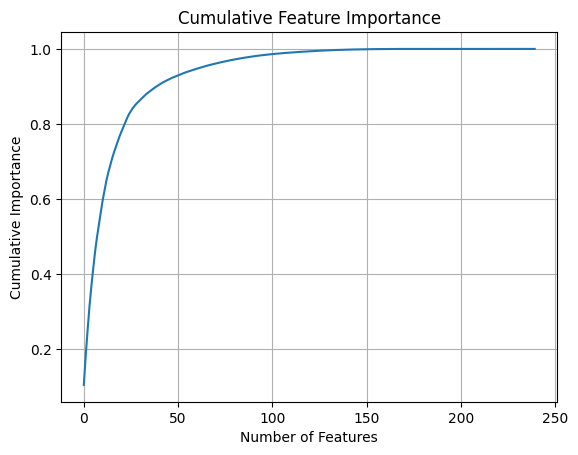

Number of features:  63
Selected Features: Index(['windspeedmin_10', 'windspeedmin_07', 'tempmax_05', 'windspeedmin_09',
       'tempmax_02', 'tempmax_06', 'precipcover_12', 'day_length_08', 'dew_04',
       'day_length_11', 'tempmax_07', 'day_length_10', 'day_length_04',
       'windspeedmax_10', 'day_length_06', 'cloudcover_08', 'dew_07',
       'day_length_02', 'humidity_09', 'day_length_01', 'solarradiation_04',
       'windspeed_10', 'tempmin_01', 'day_length_12', 'humidity_05',
       'windgust_08', 'solarenergy_02', 'windspeed_04', 'uvindex_05',
       'temp_01', 'windspeedmean_06', 'day_length_03', 'day_length_09',
       'uvindex_03', 'windgust_09', 'windspeedmax_05', 'windspeedmax_11',
       'precip_12', 'sealevelpressure_02', 'tempmin_08', 'day_length_05',
       'dew_02', 'humidity_07', 'sealevelpressure_06', 'snowdepth_01',
       'tempmax_08', 'humidity_08', 'day_length_07', 'cloudcover_09',
       'cloudcover_11', 'cloudcover_03', 'sealevelpressure_01', 'windspeed_09',


In [52]:
cumulative_importance = np.cumsum(feature_importances[indices])
plt.plot(range(len(cumulative_importance)), cumulative_importance)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance')
plt.grid(True)
plt.show()

selected_features = X.columns[indices][:np.argmax(cumulative_importance >= threshold) + 1]
print("Number of features: ", len(selected_features))
print("Selected Features:", selected_features)

### Optimal Version

In [53]:
# Subset the data based on the selected features
X_train_scaled_opt = scaler.fit_transform(X_train[selected_features.tolist()])
X_test_scaled_opt = scaler.transform(X_test[selected_features.tolist()])

In [54]:
# Define the expanded parameter grid
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'epsilon': [0.01, 0.1, 0.2, 0.5, 1.0],  # Epsilon parameter
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'degree': [2, 3, 4, 5],  # Degree of the polynomial kernel
    'coef0': [0.0, 0.1, 0.5, 1.0]  # Independent term in the kernel function
}

# Initialize the Support Vector Regressor
model = SVR()

# Initialize StandardScaler
scaler = StandardScaler()

# Optionally, scale features
X_train_scaled_opt = scaler.fit_transform(X_train_scaled_opt)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train_scaled_opt, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_model = SVR(**best_params)
best_model.fit(X_train_scaled_opt, y_train)

# Optionally, you can print the best hyperparameters
print("Best Hyperparameters:", best_params)

KeyboardInterrupt: 

In [ ]:
# Initialize and train the Support Vector Regressor
model = SVR(**best_params)
model.fit(X_train_scaled_opt, y_train)

In [ ]:
y_pred_int = get_predictions(X_test_scaled_opt, model)

In [ ]:
evaluate_model(y_test, y_pred_int)